In [1]:
from importdata import data
from fft import *
from mobility import *
from permutationentropy import *
from utils import *
from lempelziv import *
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from parameters import *

import matplotlib.pyplot as plt


This cell trims the data, in each case it is assumed that if the BIS and EEG data have different durations, the one with the longer duration was started earlier.

In [2]:
for case in data:
    eeg_duration = case['EEG'].shape[1]/sampling_rate
    print(case['EEG'].shape)
    bis_duration = case['bis'].shape[1]/bis_sampling_rate
    print(f'eeg duration: {eeg_duration}')
    print(f'bis_duration: {bis_duration}')
    if bis_duration > eeg_duration:
        difference = bis_duration - eeg_duration
        trim_length = int(round(difference * bis_sampling_rate))
        case['bis'] = case['bis'][:,  :case['bis'].shape[1] - trim_length]
    else:
        difference = eeg_duration - bis_duration
        trim_length = int(round(difference * sampling_rate))
        case['EEG'] = case['EEG'][:, trim_length :]
    eeg_duration = case['EEG'].shape[1]/sampling_rate
    bis_duration = case['bis'].shape[1]/bis_sampling_rate
    print(f'new eeg duration: {eeg_duration}')
    print(f'new bis_duration: {bis_duration}')
    



(1, 481384)
eeg duration: 3851.072
bis_duration: 3835.0
new eeg duration: 3835.0
new bis_duration: 3835.0
(1, 625664)
eeg duration: 5005.312
bis_duration: 5010.0
new eeg duration: 5005.312
new bis_duration: 5005.0
(1, 1673152)
eeg duration: 13385.216
bis_duration: 13380.0
new eeg duration: 13380.0
new bis_duration: 13380.0
(1, 499040)
eeg duration: 3992.32
bis_duration: 4010.0
new eeg duration: 3992.32
new bis_duration: 3990.0
(1, 309728)
eeg duration: 2477.824
bis_duration: 2490.0
new eeg duration: 2477.824
new bis_duration: 2480.0
(1, 643392)
eeg duration: 5147.136
bis_duration: 5175.0
new eeg duration: 5147.136
new bis_duration: 5145.0
(1, 775008)
eeg duration: 6200.064
bis_duration: 6205.0
new eeg duration: 6200.064
new bis_duration: 6200.0
(1, 1017568)
eeg duration: 8140.544
bis_duration: 8145.0
new eeg duration: 8140.544
new bis_duration: 8140.0
(1, 765172)
eeg duration: 6121.376
bis_duration: 6125.0
new eeg duration: 6121.376
new bis_duration: 6120.0
(1, 793568)
eeg duration: 63

In [3]:

eeg_data = [case['EEG'][0] for case in data] #converts to single dimension list
bis_data = [case['bis'][0] for case in data]

eeg_train_data = eeg_data[::2]


signal_lengths = [len(case) for case in eeg_train_data]


In [4]:
decomposed_eeg_train_data = [fft(case, sampling_rate) for case in eeg_train_data] 
decomposed_eeg_train_time_domain = convert_decomposed_to_time_domain(decomposed_eeg_train_data) 
decomposed_eeg_train_time_domain_power = convert_decomposed_amplitude_to_power(decomposed_eeg_train_time_domain) 


In [5]:
mobility_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, calculate_mobility, sampling_rate, signal_lengths, mobility_window_duration, mobility_overlap_fraction)
pe_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, PE, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)
lzc_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, LZC_single_band, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)

mobility_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, calculate_mobility, sampling_rate, signal_lengths, mobility_window_duration, mobility_overlap_fraction)
pe_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, PE, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)
lzc_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, LZC_single_band, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)

In [6]:
bis_train_data = bis_data[::2]

In [7]:
mobility_amplitude_bis_train_dict = associate_features_with_BIS(mobility_amplitude_array_train, bis_train_data, mobility_window_duration, mobility_overlap_fraction, bis_sampling_rate)
mobility_amplitude_train_r2 = linear_regression(mobility_amplitude_bis_train_dict)
print(f'mobility amplitude train r2{mobility_amplitude_train_r2}')

mobility_power_bis_train_dict = associate_features_with_BIS(mobility_power_array_train, bis_train_data, mobility_window_duration, mobility_overlap_fraction, bis_sampling_rate)
mobility_power_train_r2 = linear_regression(mobility_power_bis_train_dict)
print(f'mobility power train r2{mobility_power_train_r2}')

pe_amplitude_bis_train_dict = associate_features_with_BIS(pe_amplitude_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
pe_amplitude_train_r2 = linear_regression(pe_amplitude_bis_train_dict)
print(f'pe amplitude train r2{pe_amplitude_train_r2}')

pe_power_bis_train_dict = associate_features_with_BIS(pe_power_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
pe_power_train_r2 = linear_regression(pe_power_bis_train_dict)
print(f'pe power train r2 {pe_power_train_r2}')

lzc_amplitude_bis_train_dict = associate_features_with_BIS(lzc_amplitude_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
lzc_amplitude_train_r2 = linear_regression(lzc_amplitude_bis_train_dict)
print(f'lzc amplitude train r2 {lzc_amplitude_train_r2}')

lzc_power_bis_train_dict = associate_features_with_BIS(lzc_power_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
lzc_power_train_r2 = linear_regression(lzc_power_bis_train_dict)
print(f'lzc power train r2 {lzc_power_train_r2}')



length feature data: 756
length of bis_flat: 756
length feature data: 2605
length of bis_flat: 2605
length feature data: 474
length of bis_flat: 474
length feature data: 1240
length of bis_flat: 1240
length feature data: 1187
length of bis_flat: 1187
length feature data: 2587
length of bis_flat: 2587
length feature data: 820
length of bis_flat: 820
length feature data: 2664
length of bis_flat: 2664
length feature data: 1556
length of bis_flat: 1556
length feature data: 881
length of bis_flat: 881
length feature data: 1900
length of bis_flat: 1900
length feature data: 1181
length of bis_flat: 1181
length feature data: 767
length of bis_flat: 767
length feature data: 2605
length of bis_flat: 2605
length feature data: 485
length of bis_flat: 485
length feature data: 1240
length of bis_flat: 1240
length feature data: 1187
length of bis_flat: 1187
length feature data: 2597
length of bis_flat: 2597
length feature data: 830
length of bis_flat: 830
length feature data: 2674
length of bis_flat:

Text(0.5, 1.0, 'Mobility')

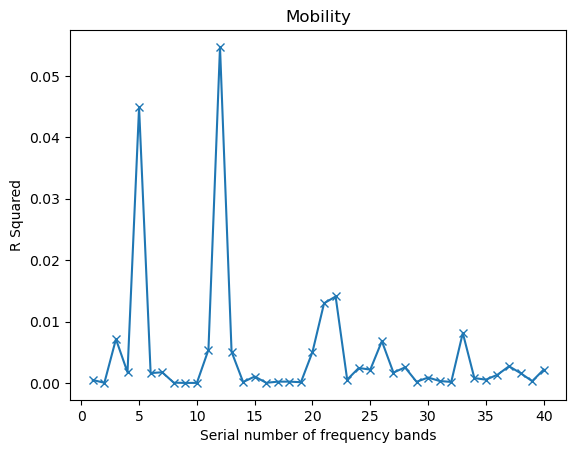

In [8]:
r2_mobility = list(mobility_amplitude_train_r2.values()) + list(mobility_power_train_r2.values())
frequency_bands_mobility = list(range(1, len(r2_mobility) + 1))

plt.plot(frequency_bands_mobility, r2_mobility, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Mobility")





Text(0.5, 1.0, 'Permutation Entropy')

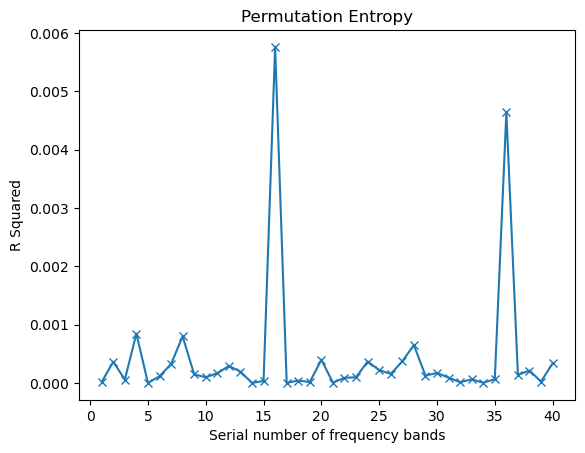

In [9]:
r2_pe = list(pe_amplitude_train_r2.values()) + list(pe_power_train_r2.values())
frequency_bands_pe = list(range(1, len(r2_pe) + 1))

plt.plot(frequency_bands_pe, r2_pe, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Permutation Entropy")

Text(0.5, 1.0, 'Lempel-Ziv Complexity')

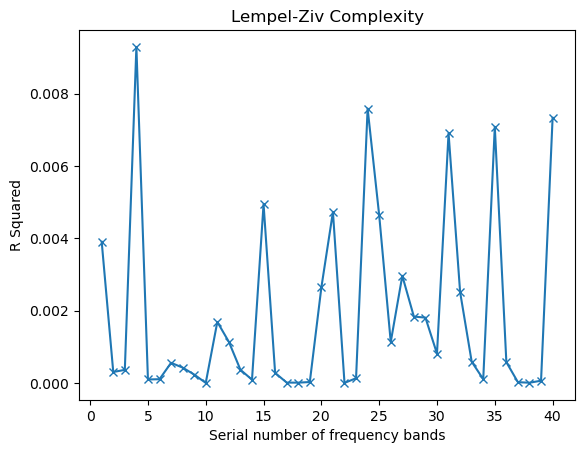

In [10]:
r2_lzc = list(lzc_amplitude_train_r2.values()) + list(lzc_power_train_r2.values())
frequency_bands_lzc = list(range(1, len(r2_lzc) + 1))

plt.plot(frequency_bands_lzc, r2_lzc, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Lempel-Ziv Complexity")